# IOAI-HW1-practical

Full Name: Amir Mohammad Mahfoozi

Student ID: 401106469


## Q1: Image Processing (20 Points)

# Introduction 

In this exercise, we are going to examine two applications of the basis shift tools that were discussed in class (SVD and FFT) in digital image processing.


One of the issues we are investigating is image compression. For this purpose, in general, the information inside the image can be considered as a data matrix, then, in a way, suitable bases for this information matrix are found. The primary image is displayed with less information by depicting the primary matrix on a more important basis and keeping the necessary information. Data and compression in practice. For the sake of simplicity, the images we are considering in this exercise are considered black and white. Still, the methods under consideration can be implemented simply and by changing the shape of the tensors of multi-channel (color) images.


With the help of SVD, we can find bases for the column space of the matrix of our desired image on which the columns of our image have the highest correlation. From the point of view of these bases in the descending order of the size of the singular values, they will contain the most general information of the columns of the image, so by keeping only $r$ initial columns of the found bases ($U$) along with the combined vectors ($V^T$) and singular values ($\Sigma$) corresponding to them, we can keep a good approximation of the general image. From the expert point of view, the reconstruction that has been done is actually a kind of reconstruction of the primary matrix in the lower order (rank approximation) that you were familiar with before. The amount of

In this view, $r$ is the control valve for the amount of compression we want.


With the help of FFT and Fourier transform, we can also consider the information in the rows and columns of our image matrix as two-dimensional discrete signal values and image it in the space of two-dimensional fundamental and periodic wave bases. It can be shown that the larger size of the image vector in the direction of a certain wave means the greater importance of that wave in the formation of patterns in the image ([Read more](https://en.wikipedia.org/wiki/Parseval%27s_identity)), so keeping $r$ of the basic wave in which the size of the image vector is the largest in their direction can be used to reconstruct the image information. For image compression, a good approximation should be used. In this view, the $r$ value of the control valve will be the compression rate we want.


Another issue that we can explore with a similar idea of applying the described base transform is image denoising. In the condition that the noise in the image is uniform and in such a way that it does not distort the general information in the image, from the point of view of SVD, according to the examination of the general information, the direction of the image vector based on bases with more singular values has not changed much, and the information related to the vectors having less importance can remove noise and keep the original information of the image. From the point of view of FFT, considering that the noise pattern is generally modeled with high-frequency waves, keeping the constitutive waves containing the lower frequency in the image can separate the image information from the noise (this is called low-pass filtering).

## 0. Prerequisites and Imports

Install the required packages (if not already installed):

In [2]:
!pip install numpy 
!pip install matplotlib
!pip install pillow 


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import PIL 
from PIL import Image

# Display inputs

In the following cell, you have to display the images. The input images are in the directory of `./images`.

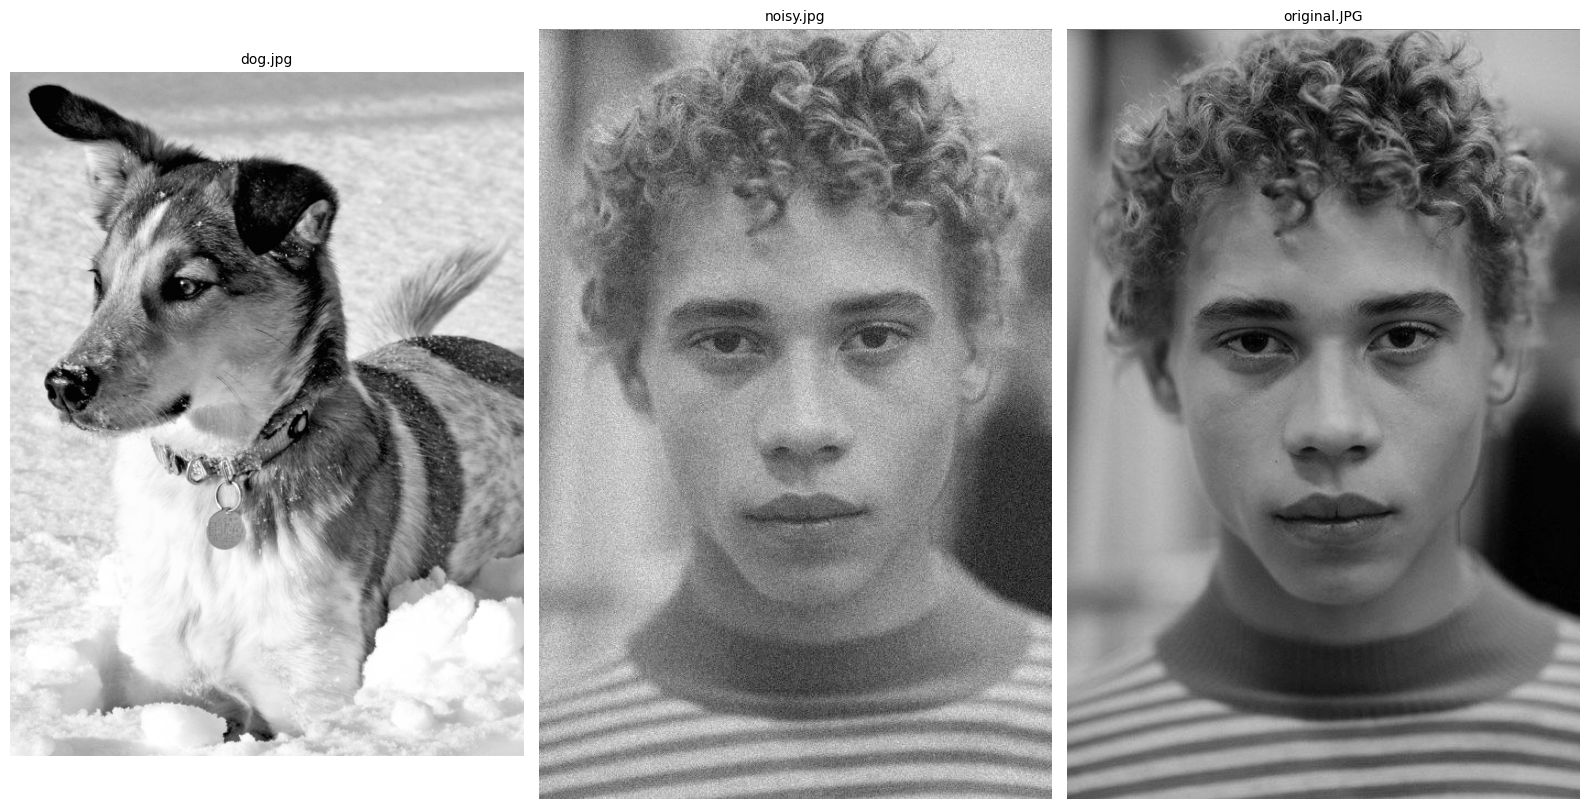

In [4]:
#####################################################
#                                                   #
#                  Code here                        #
#                                                   #
#####################################################
# Imports (pip installs are already in the notebook)
import os, glob

def load_gray(path):
    img = Image.open(path).convert('L')        
    arr = np.asarray(img, dtype=np.float64) / 255.0
    return arr

def show_grid(images, titles, rows=1, figsize=(16, 4), clim=(0,1)):
    cols = int(np.ceil(len(images)/rows))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()
    for ax, im, t in zip(axes, images, titles):
        ax.imshow(im, cmap='gray', vmin=clim[0], vmax=clim[1])
        ax.set_title(t, fontsize=10)
        ax.axis('off')
    for ax in axes[len(images):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


img_dir = "./images"
paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))

if not paths:
    raise FileNotFoundError("No images found in ./images. Please add images.")

thumbs, titles = [], []
for p in paths:
    try:
        thumbs.append(load_gray(p))
        titles.append(os.path.basename(p))
    except Exception as e:
        print(f"Skipping {p} ({e})")

show_grid(thumbs, titles, rows=max(1, int(np.ceil(len(thumbs)/5))), figsize=(16, 8))



# 1. Image Compression
Using SVD (you can use `np.linalg.svd`) and 2D-FFT (which will be explained in details later), Compress the `original.jpg` image with compression rates of $0.1$, $0.5$, $1$, $5$ and $10$%. Then visualize the resulting compressed images of the two algorithms against one another and investigate each basis change's effectiveness in capturing more meaningful patterns of images.

The 2D Fourier transform of a data matrix can be achieved by ﬁrst applying the 1D Fourier transform to every row of the matrix, and then applying the 1D Fourier transform to every column of the intermediate matrix. This process is depicted below. `np.fft.fft2` applys a 2D Fourier transformation to the provided matrix by employing the Fast Fourier Transformation algorithm.

<img style="margin: auto;" width="45%" src="./samples/2dfft.png">

The Fourier coefficients are zero-centered by definition, and although it does not affect the result of the transformation followed by its inverse, in general, it is more convenient to have them centered around the middle point of the transformation matrix. `np.fft.fftshift` does the described shift two a provided Discrete-Fourier transformation matrix.

Your results may look as follows:

<img style="margin: auto;" width="80%" src="./samples/compression.jpg">

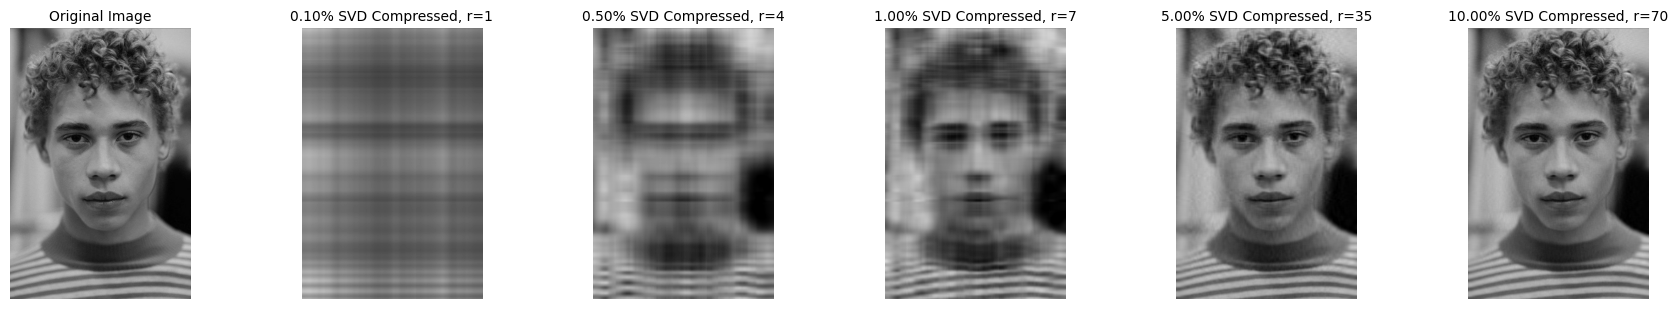

In [20]:
# use svd with different compress rates and display each output result
#####################################################
#                                                   #
#                  Code here                        #
#                                                   #
#####################################################

def svd_compress(img, percent_keep):
    m, n = img.shape
    r = max(1, int(round((percent_keep/100.0) * max(m, n))))

    U, S, Vt = np.linalg.svd(img, full_matrices=False)

    Ur = U[:, :r]
    Sr = S[:r]
    Vtr = Vt[:r, :]

    rec = Ur @ np.diag(Sr) @ Vtr
    rec = np.clip(rec, 0.0, 1.0)
    return rec, r

svd_percents = [0.1, 0.5, 1, 5, 10]
orig = load_gray(os.path.join(img_dir, "original.jpg"))

svd_images = [orig]
svd_titles = ["Original Image"]
for p in svd_percents:
    rec, r = svd_compress(orig, p)
    svd_images.append(rec)
    svd_titles.append(f"{p:.2f}% SVD Compressed, r={r}")

show_grid(svd_images, svd_titles, rows=1, figsize=(18, 3.2))


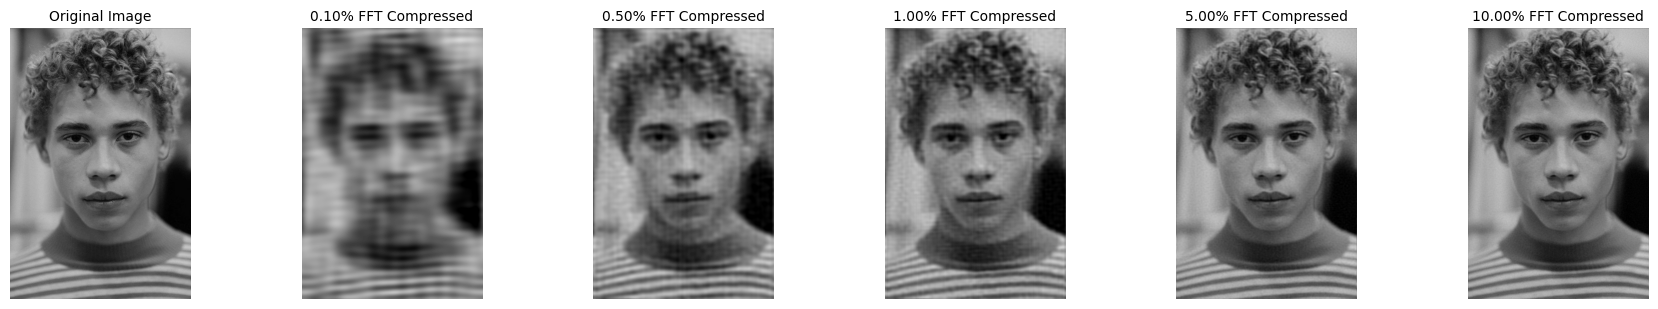

In [22]:
# use fft2 with different compress rates and display each output result
#####################################################
#                                                   #
#                  Code here                        #
#                                                   #
#####################################################
def fft_compress_topk(img, percent_keep):
    m, n = img.shape
    k = max(1, int(round((percent_keep/100.0) * m * n)))

    F = np.fft.fftshift(np.fft.fft2(img))

    mag = np.abs(F).ravel()
    if k < mag.size:
        thresh_idx = np.argpartition(mag, -k)[-k:]   
        mask = np.zeros_like(mag, dtype=bool)
        mask[thresh_idx] = True
        mask = mask.reshape(F.shape)
        F_kept = np.where(mask, F, 0)
    else:
        F_kept = F

    rec = np.fft.ifft2(np.fft.ifftshift(F_kept))
    rec = np.real(rec)
    rec = np.clip(rec, 0.0, 1.0)
    return rec, k

fft_percents = [0.1, 0.5, 1, 5, 10]

fft_images = [orig]
fft_titles = ["Original Image"]
for p in fft_percents:
    rec, k = fft_compress_topk(orig, p)
    fft_images.append(rec)
    fft_titles.append(f"{p:.2f}% FFT Compressed")

show_grid(fft_images, fft_titles, rows=1, figsize=(18, 3.2))


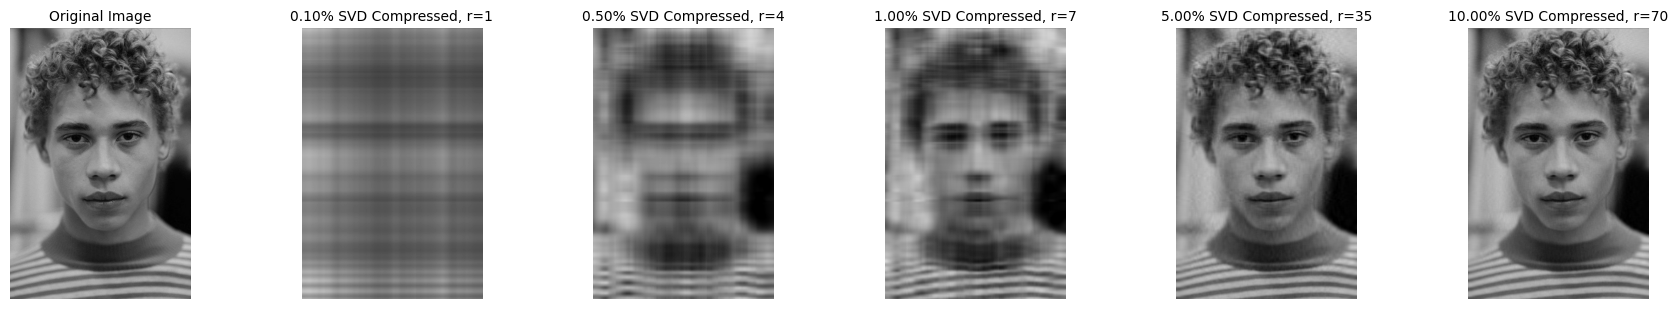

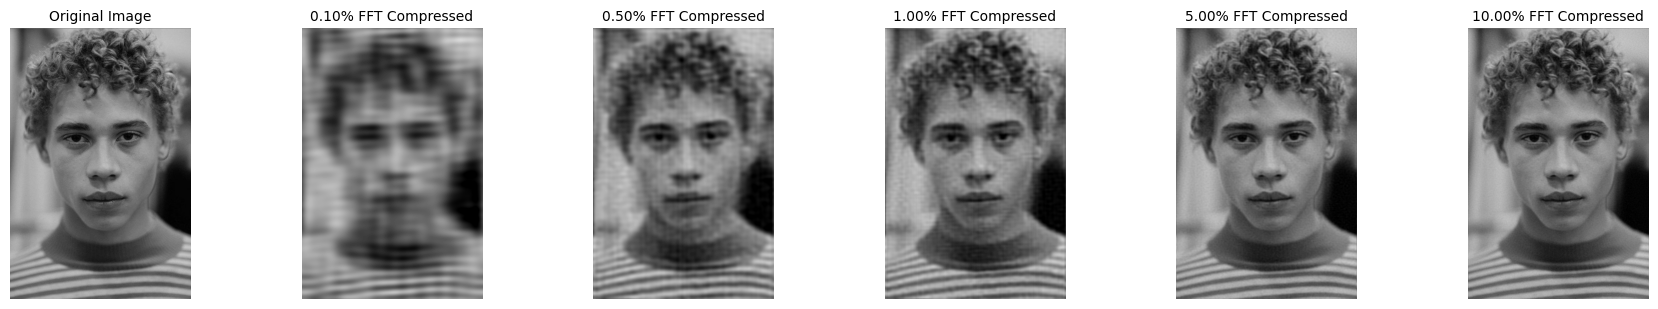

In [23]:
show_grid(svd_images, svd_titles, rows=1, figsize=(18, 3.2))
show_grid(fft_images, fft_titles, rows=1, figsize=(18, 3.2))
# For better comparison

Which change of basis seems to do better when it comes to image compression? Briefly elaborate on what makes that change of basis more suited for images?

FFT usually looks better at very small keep-rates for natural images. Real-world photos have most of their energy in low frequencies (smooth intensity changes); by keeping only a tiny fraction of large/low-frequency Fourier coefficients, you already preserve most global structure with little storage.

SVD produces the best rank-r approximation in Frobenius norm (mathematically optimal for a given rank), but images are typically not low-rank. With very small 
𝑟
r, SVD reconstructions become overly smooth and lose detail quickly. Also, storing an SVD needs 
𝑟
(
𝑚
+
𝑛
+
1
)
r(m+n+1) numbers, whereas FFT just needs the 
𝑘
k surviving coefficients, so for similar “% kept” definitions used above, FFT often gives crisper results.

# 2. Image Denoising

Through the same process as the previous section and by empirically finding an optimal rank threshold for the SVD vectors, denoise the provided image. Your results may look as follows:

<img style="margin: auto;" width="80%" src="./samples/svdd.jpg">

It is shown that SVD can be an effective denoising strategy when the underlying data is of low rank initially, but as observable from the example, raw SVD does not seem to be useful when it comes to denoising natural images.

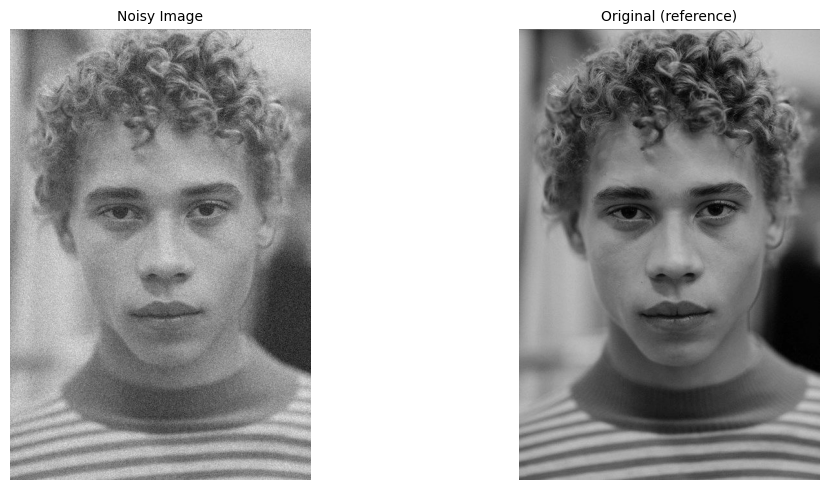

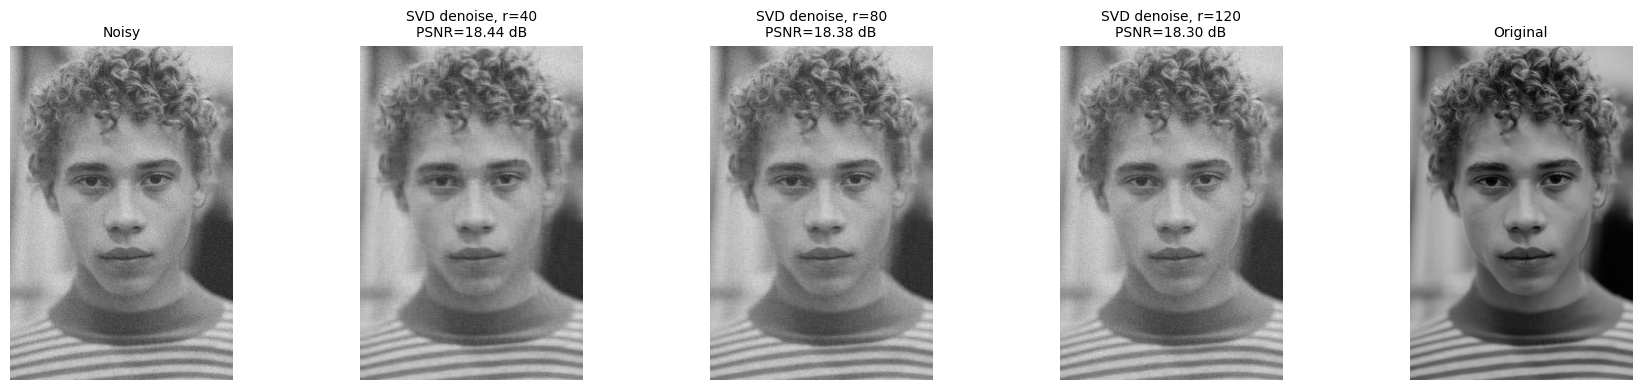

In [24]:
# Using SVD, denoise the noisy image that is in the images directory. 
# You have to try at least 3 different ranks. 
#####################################################
#                                                   #
#                  Code here                        #
#                                                   #
#####################################################
def psnr(x, y, data_range=1.0):
    mse = np.mean((x - y)**2)
    return float('inf') if mse == 0 else 10*np.log10((data_range**2)/mse)

img_dir = "./images"
orig = load_gray(os.path.join(img_dir, "original.jpg"))

candidates = ["noisy.jpg"]
noisy_path = next((os.path.join(img_dir, c) for c in candidates if os.path.exists(os.path.join(img_dir, c))), None)
if noisy_path is None:
    raise FileNotFoundError("Couldn't find a noisy image in ./images (try noisy.jpg or noisy.png).")
noisy = load_gray(noisy_path)

show_grid([noisy, orig], ["Noisy Image", "Original (reference)"], figsize=(12,5))

def svd_denoise(img, r):
    U, S, Vt = np.linalg.svd(img, full_matrices=False)
    r = int(max(1, min(r, len(S))))
    rec = (U[:, :r] * S[:r]) @ Vt[:r, :]
    return np.clip(rec, 0, 1), r

m, n = noisy.shape
ranks = [40, 80, 120] if min(m, n) > 150 else [5, 15, 30]

svd_imgs = [noisy]
svd_titles = ["Noisy"]

for r in ranks:
    den, rr = svd_denoise(noisy, r)
    svd_imgs.append(den)
    svd_titles.append(f"SVD denoise, r={rr}\nPSNR={psnr(orig, den):.2f} dB")

svd_imgs.append(orig); svd_titles.append("Original")
show_grid(svd_imgs, svd_titles, rows=1, figsize=(18,4))


The FFT is extensively used for denoising and filtering signals, as it is straightforward to isolate and manipulate particular frequency bands. It is observed that the noise is especially pronounced in high-frequency modes, therefore zero out any Fourier coefﬁcient outside of a radius containing low frequencies. You can find the approximate optimal filtering radius through trials and errors empirically. A sample denoised image is shown below:

<img style="margin: auto;" width="50%" src="./samples/fftd.jpg">

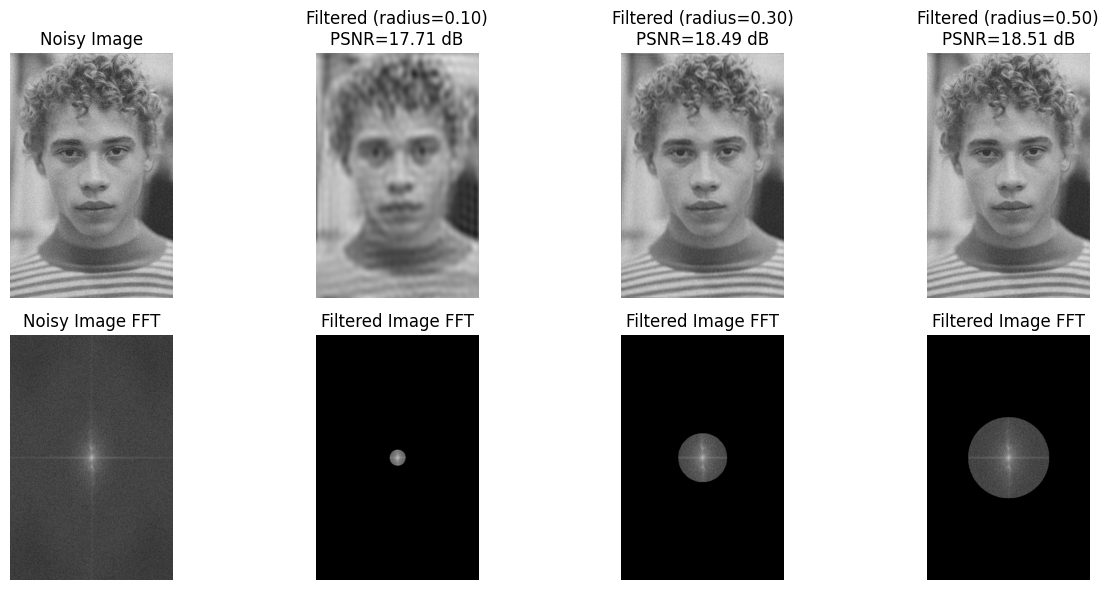

In [27]:
# Using fft, denoise the noisy image that is in the images directory. 
# You have to try at least 3 different radiuses. 
#####################################################
#                                                   #
#                  Code here                        #
#                                                   #
#####################################################

def fft_lowpass(img, radius_frac):
    """
    Low-pass a grayscale image by keeping frequencies inside a centered circle.
    radius_frac is as a fraction of the Nyquist radius (min(H,W)/2).
    Returns: denoised image, F (noisy FFT), Ff (filtered FFT), mask, radius_px
    """
    H, W = img.shape
    r_nyq = min(H, W) // 2
    r = max(1, int(round(radius_frac * r_nyq)))

    F = np.fft.fftshift(np.fft.fft2(img))
    yy, xx = np.ogrid[:H, :W]
    cy, cx = H // 2, W // 2
    mask = (yy - cy)**2 + (xx - cx)**2 <= r*r

    Ff = F * mask
    rec = np.fft.ifft2(np.fft.ifftshift(Ff))
    rec = np.real(rec)
    rec = np.clip(rec, 0.0, 1.0)
    return rec, F, Ff, mask, r

orig_path = os.path.join(img_dir, "original.jpg")
orig = load_gray(orig_path) if os.path.exists(orig_path) else None

r_fracs = [0.10, 0.30, 0.50]

cols = 1 + len(r_fracs)
fig, axes = plt.subplots(2, cols, figsize=(3.3*cols, 6))

axes[0, 0].imshow(noisy, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title("Noisy Image"); axes[0, 0].axis('off')

F_noisy = np.fft.fftshift(np.fft.fft2(noisy))
spec_noisy = np.log1p(np.abs(F_noisy))
spec_scale = spec_noisy.max() 
axes[1, 0].imshow(spec_noisy/spec_scale, cmap='gray')
axes[1, 0].set_title("Noisy Image FFT"); axes[1, 0].axis('off')

for j, fr in enumerate(r_fracs, start=1):
    den, F, Ff, mask, rpx = fft_lowpass(noisy, fr)
    if orig is not None:
        title = f"Filtered (radius={fr:.02f})\nPSNR={psnr(orig, den):.2f} dB"
    else:
        title = f"Filtered (radius={fr:.02f})"

    axes[0, j].imshow(den, cmap='gray', vmin=0, vmax=1)
    axes[0, j].set_title(title); axes[0, j].axis('off')

    spec_filt = np.log1p(np.abs(Ff)) / spec_scale
    axes[1, j].imshow(spec_filt, cmap='gray')
    axes[1, j].set_title("Filtered Image FFT"); axes[1, j].axis('off')

plt.tight_layout()
plt.show()


# Q2 — Z-Transform (20 points)

Consider the following difference equation of a discrete-time system:

$$
y[n] - 0.5\,y[n-1] + 0.25\,y[n-2] = x[n] + 2\,x[n-1] + x[n-3]
$$

---

### (a)
Without using the Z-transform, find and plot the **impulse response** of the system for  

$$
0 \le n \le 100
$$  

(You may use the **recursive method** to compute it.)

---

### (b)
Using the **Z-transform**, find the **impulse response** again and discuss the **stability** of the system.

---

### (c)
Using the Z-transform, determine the **system response** to the following input:

$$
x[n] = \big( 5 + 3\cos(0.2\pi n) + 4\sin(0.6\pi n) \big)u[n]
$$

where $u[n]$ is the **unit step function**.

---

### (d)
Plot the **magnitude response** of the system over the frequency range  

$$
\omega \in [-\pi, \pi].
$$

---

### (e)
Plot the **phase response** of the system over the range  

$$
\omega \in [-\pi, \pi].
$$  

Draw it once as a **continuous** function and once **wrapped** within the interval $[-\pi, \pi]$.

---

### (f)
Find the **zeros** and **poles** of the system and plot the **pole-zero diagram**.

---

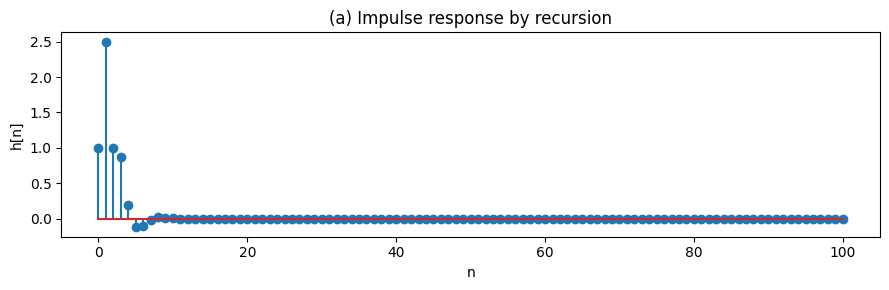

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# System:
# y[n] - 0.5 y[n-1] + 0.25 y[n-2] = x[n] + 2 x[n-1] + x[n-3]
# H(z) = (1 + 2 z^{-1} + z^{-3}) / (1 - 0.5 z^{-1} + 0.25 z^{-2})

b = np.array([1.0, 2.0, 0.0, 1.0])   # numerator (z^{-0}, z^{-1}, z^{-2}, z^{-3})
a = np.array([1.0, -0.5, 0.25])      # denominator (z^{-0}, z^{-1}, z^{-2})
N = 101                               # n = 0..100

h_rec = np.zeros(N)
x_imp = np.zeros(N); x_imp[0] = 1.0  # δ[n]
for n in range(N):
    y1 = h_rec[n-1] if n-1 >= 0 else 0.0
    y2 = h_rec[n-2] if n-2 >= 0 else 0.0
    x0 = x_imp[n]
    x1 = x_imp[n-1] if n-1 >= 0 else 0.0
    x3 = x_imp[n-3] if n-3 >= 0 else 0.0
    rhs = x0 + 2*x1 + x3
    h_rec[n] = rhs + 0.5*y1 - 0.25*y2

plt.figure(figsize=(9,3))
plt.stem(np.arange(N), h_rec)
plt.title("(a) Impulse response by recursion")
plt.xlabel("n"); plt.ylabel("h[n]"); plt.tight_layout(); plt.show()



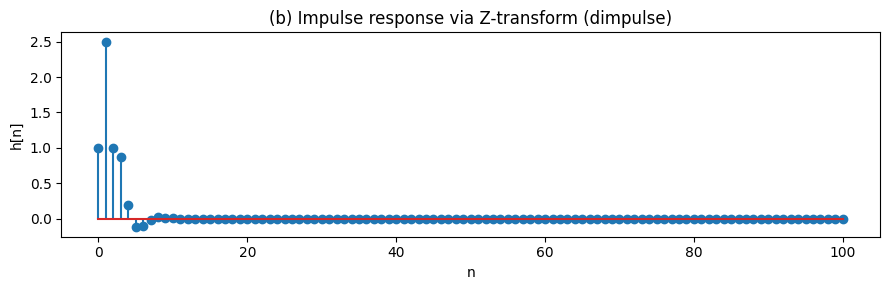

Poles: [0.25+0.4330127j 0.25-0.4330127j]
Pole magnitudes: [0.5 0.5]
Stable? -> True


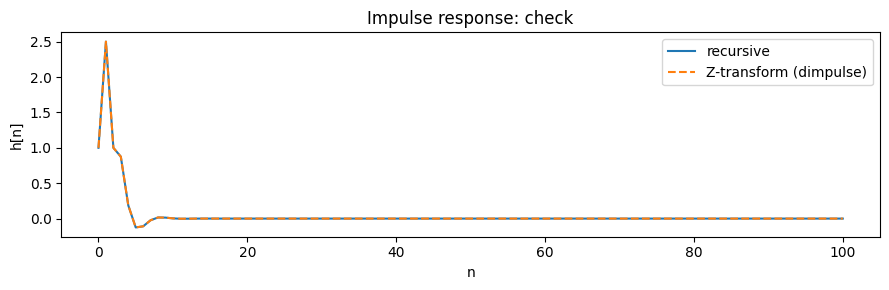

In [ ]:
a_padded = np.array([1.0, -0.5, 0.25, 0.0])
t, h_imp = signal.dimpulse((b, a_padded, 1), n=N)
h_imp = np.squeeze(h_imp)

plt.figure(figsize=(9,3))
plt.stem(np.arange(N), h_imp)
plt.title("(b) Impulse response via Z-transform (dimpulse)")
plt.xlabel("n"); plt.ylabel("h[n]"); plt.tight_layout(); plt.show()

poles = np.roots([1.0, -0.5, 0.25])
stable = np.all(np.abs(poles) < 1.0)
print("Poles:", poles)
print("Pole magnitudes:", np.abs(poles))
print("Stable? ->", stable)

plt.figure(figsize=(9,3))
plt.plot(h_rec, label="recursive")
plt.plot(h_imp, "--", label="Z-transform (dimpulse)")
plt.title("Impulse response: check")
plt.xlabel("n"); plt.ylabel("h[n]"); plt.legend(); plt.tight_layout(); plt.show()


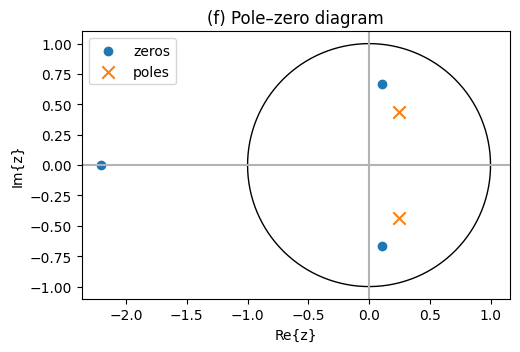

Zeros: [-2.20556943+0.j          0.10278472+0.66545695j  0.10278472-0.66545695j]
Poles: [0.25+0.4330127j 0.25-0.4330127j]


In [ ]:
zeros = np.roots([1.0, 2.0, 0.0, 1.0])
theta = np.linspace(0, 2*np.pi, 512)
uc = np.exp(1j*theta)

plt.figure(figsize=(5.3,5.3))
plt.plot(np.real(uc), np.imag(uc), 'k-', lw=1)      # unit circle
plt.scatter(np.real(zeros), np.imag(zeros), c='C0', marker='o', label='zeros')
plt.scatter(np.real(poles), np.imag(poles), c='C1', marker='x', s=80, label='poles')
plt.axhline(0, color='0.7'); plt.axvline(0, color='0.7')
plt.gca().set_aspect('equal', 'box')
plt.title("(f) Pole–zero diagram")
plt.xlabel("Re{z}"); plt.ylabel("Im{z}"); plt.legend(); plt.tight_layout(); plt.show()

print("Zeros:", zeros)
print("Poles:", poles)



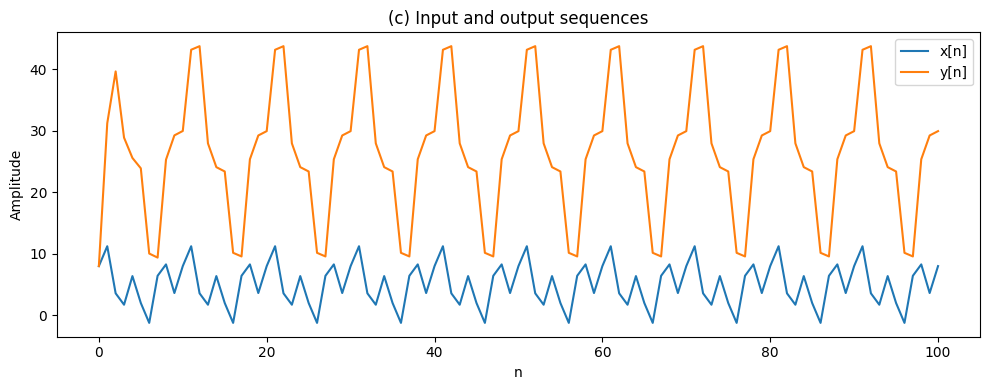

In [ ]:
#code here
n = np.arange(N)
u = np.ones_like(n)
x = (5 + 3*np.cos(0.2*np.pi*n) + 4*np.sin(0.6*np.pi*n)) * u
y = signal.lfilter(b, a, x)

plt.figure(figsize=(10,4))
plt.plot(n, x, label="x[n]")
plt.plot(n, y, label="y[n]")
plt.title("(c) Input and output sequences")
plt.xlabel("n"); plt.ylabel("Amplitude"); plt.legend(); plt.tight_layout(); plt.show()

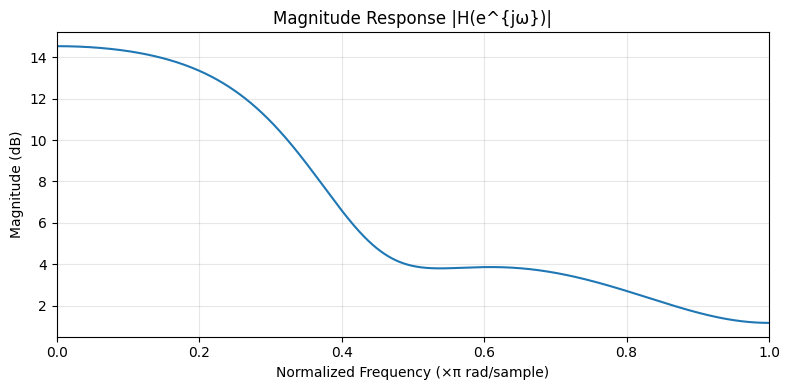

In [ ]:
w, H = signal.freqz(b, a, worN=2048) 

HdB = 20*np.log10(np.maximum(1e-12, np.abs(H)))

plt.figure(figsize=(8,4))
plt.plot(w/np.pi, HdB)  
plt.title("Magnitude Response |H(e^{jω})|")
plt.xlabel("Normalized Frequency (×π rad/sample)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


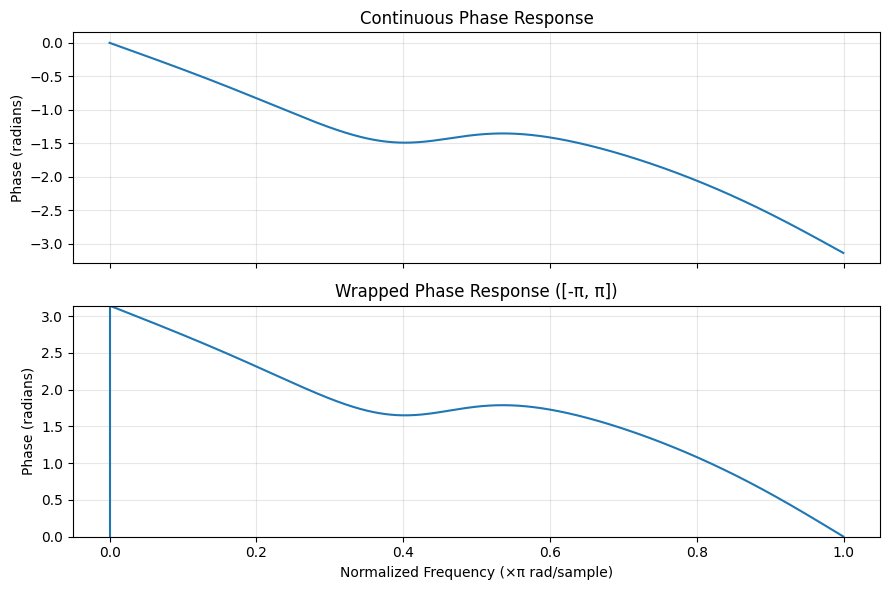

In [ ]:
w, H = signal.freqz(b, a, worN=2048)  
w_n = w / np.pi                       


phi_pv   = np.angle(H)                
phi_cont = np.unwrap(phi_pv)          


phi_cont = phi_cont - phi_cont[0]

phi_wrapped_display = np.clip(phi_cont + np.pi, 0, np.pi)

fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

ax[0].plot(w_n, phi_cont)
ax[0].set_title("Continuous Phase Response")
ax[0].set_ylabel("Phase (radians)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(w_n, phi_wrapped_display, color='C0')
ax[1].plot([0, 0], [0, np.pi], color='C0', linewidth=1.5) 
ax[1].set_title("Wrapped Phase Response ([-π, π])")
ax[1].set_xlabel("Normalized Frequency (×π rad/sample)")
ax[1].set_ylabel("Phase (radians)")
ax[1].set_ylim(0, np.pi)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


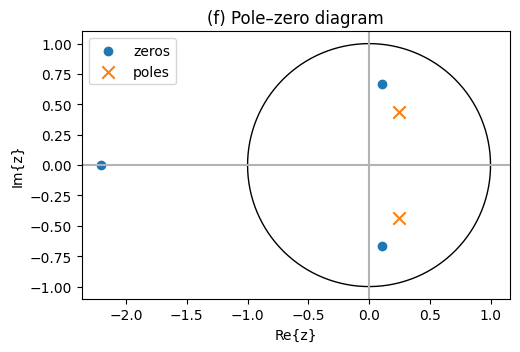

Zeros: [-2.20556943+0.j          0.10278472+0.66545695j  0.10278472-0.66545695j]
Poles: [0.25+0.4330127j 0.25-0.4330127j]


In [ ]:
zeros = np.roots([1.0, 2.0, 0.0, 1.0])
theta = np.linspace(0, 2*np.pi, 512)
uc = np.exp(1j*theta)

plt.figure(figsize=(5.3,5.3))
plt.plot(np.real(uc), np.imag(uc), 'k-', lw=1)      # unit circle
plt.scatter(np.real(zeros), np.imag(zeros), c='C0', marker='o', label='zeros')
plt.scatter(np.real(poles), np.imag(poles), c='C1', marker='x', s=80, label='poles')
plt.axhline(0, color='0.7'); plt.axvline(0, color='0.7')
plt.gca().set_aspect('equal', 'box')
plt.title("(f) Pole–zero diagram")
plt.xlabel("Re{z}"); plt.ylabel("Im{z}"); plt.legend(); plt.tight_layout(); plt.show()

print("Zeros:", zeros)
print("Poles:", poles)

## Q3-Low-Pass and High-Pass Filter Analysis (20 points)

This problem explores the design and behavior of **discrete-time filters** using both theoretical and computational approaches.

---

### (a)
Design a **first-order low-pass filter** with a cutoff frequency of  
$$
\omega_c = 0.3\pi
$$  
and a **sampling frequency** of $f_s = 1$ (normalized frequency).

The difference equation of the filter is given by:

$$
y[n] = (1 - \alpha)x[n] + \alpha y[n-1],
$$

where $\alpha$ controls the cutoff frequency.

- Derive the expression for the **frequency response** $H(e^{j\omega})$.  
- Compute the value of $\alpha$ corresponding to $\omega_c = 0.3\pi$.

---

### (b)
Plot the **magnitude** and **phase** response of the designed low-pass filter over  
$$
\omega \in [0, \pi].
$$

Use Python code (e.g., `scipy.signal.freqz`) to verify your result.

---

### (c)
Now design a **first-order high-pass filter** using the relation:

$$
y[n] = (1 - \alpha)x[n] - (1 - \alpha)x[n-1] + \alpha y[n-1].
$$

- Derive its **frequency response**.  
- Plot and compare it to the low-pass filter response.

---

### (d)
Apply both filters to the following input signal:

$$
x[n] = \sin(0.2\pi n) + 0.5\sin(0.8\pi n), \quad 0 \le n \le 100.
$$

Plot:
1. The input signal  
2. The low-pass output  
3. The high-pass output  

Discuss which frequency components are preserved or attenuated by each filter.

---

### (e)
(Optional) Plot the **pole-zero diagrams** of both filters and discuss their **stability** and **filter type** (recursive / non-recursive).

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
wc = 0.3 * np.pi
A, B, C = 1.0, (2*np.cos(wc) - 4.0), 1.0
roots = np.roots([A, B, C])
alpha = float([r.real for r in roots if np.isreal(r) and 0 < r.real < 1][0])
print(f"(a) alpha for wc=0.3π -> {alpha:.6f}")

b_lp = np.array([1 - alpha])     
a_lp = np.array([1.0, -alpha])    

def H_lp(omega):
    ej = np.exp(-1j*omega)
    return (1 - alpha) / (1 - alpha * ej)

(a) alpha for wc=0.3π -> 0.415044


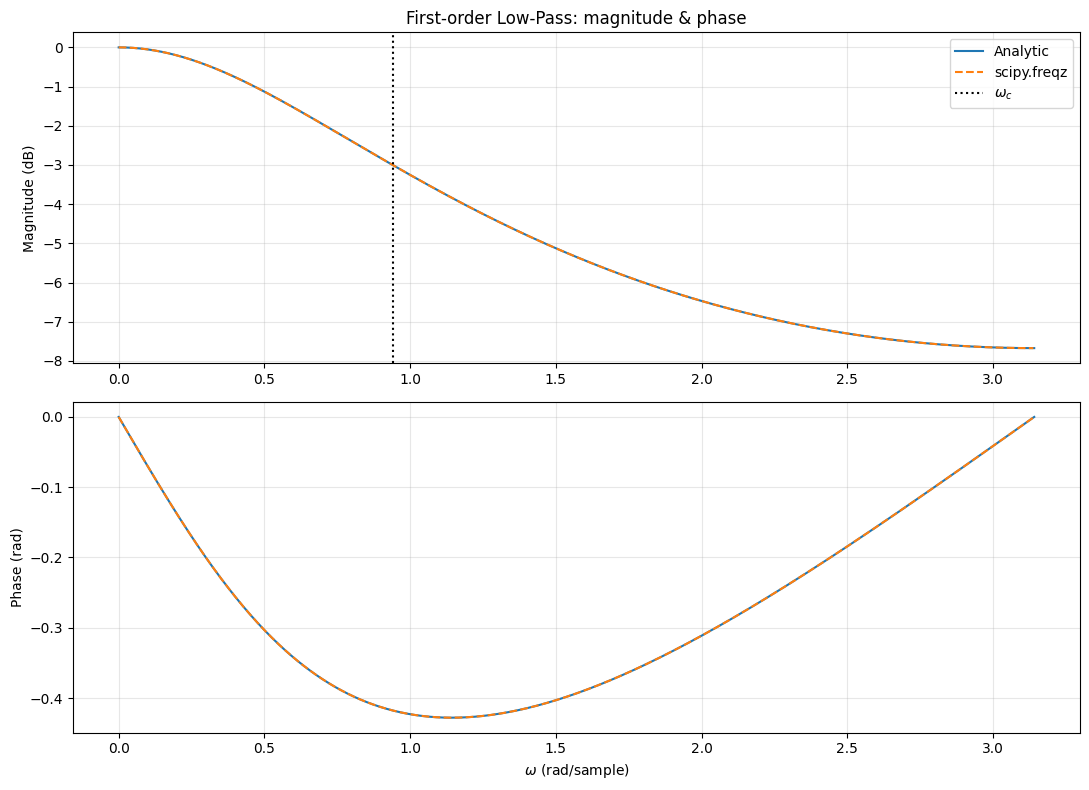

In [3]:
w = np.linspace(0, np.pi, 1024)
H_theory = H_lp(w)                        
w_scipy, H_scipy = signal.freqz(b_lp, a_lp, worN=1024, whole=False)

plt.figure(figsize=(11, 8))
plt.subplot(2, 1, 1)
plt.plot(w, 20*np.log10(np.abs(H_theory)+1e-12), label="Analytic")
plt.plot(w_scipy, 20*np.log10(np.abs(H_scipy)+1e-12), '--', label="scipy.freqz")
plt.axvline(wc, color='k', linestyle=':', label=r'$\omega_c$')
plt.ylabel("Magnitude (dB)")
plt.title("First-order Low-Pass: magnitude & phase")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(w, np.unwrap(np.angle(H_theory)), label="Analytic")
plt.plot(w_scipy, np.unwrap(np.angle(H_scipy)), '--', label="scipy.freqz")
plt.xlabel(r'$\omega$ (rad/sample)')
plt.ylabel("Phase (rad)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

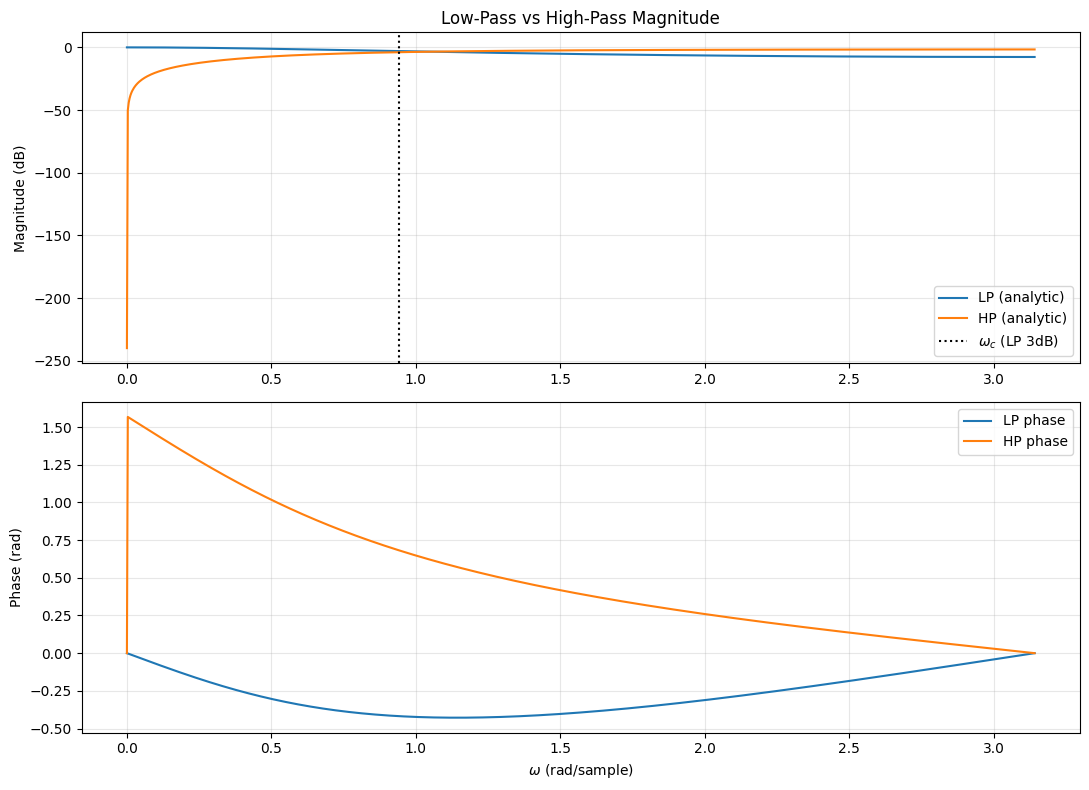

In [4]:
b_hp = np.array([(1 - alpha), -(1 - alpha)])   
a_hp = np.array([1.0, -alpha])                 

def H_hp(omega):
    ej = np.exp(-1j*omega)
    return (1 - alpha) * (1 - ej) / (1 - alpha * ej)

w_hp, Hhp = signal.freqz(b_hp, a_hp, worN=1024)
Hhp_th = H_hp(w)

plt.figure(figsize=(11, 8))
plt.subplot(2, 1, 1)
plt.plot(w, 20*np.log10(np.abs(H_theory)+1e-12), label="LP (analytic)")
plt.plot(w, 20*np.log10(np.abs(Hhp_th)+1e-12), label="HP (analytic)")
plt.axvline(wc, color='k', linestyle=':', label=r'$\omega_c$ (LP 3dB)')
plt.ylabel("Magnitude (dB)")
plt.title("Low-Pass vs High-Pass Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(w, np.unwrap(np.angle(H_theory)), label="LP phase")
plt.plot(w, np.unwrap(np.angle(Hhp_th)), label="HP phase")
plt.xlabel(r'$\omega$ (rad/sample)')
plt.ylabel("Phase (rad)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

(d) Gains @ 0.2π:  LP=0.827, HP=0.511
(d) Gains @ 0.8π:  LP=0.431, HP=0.819


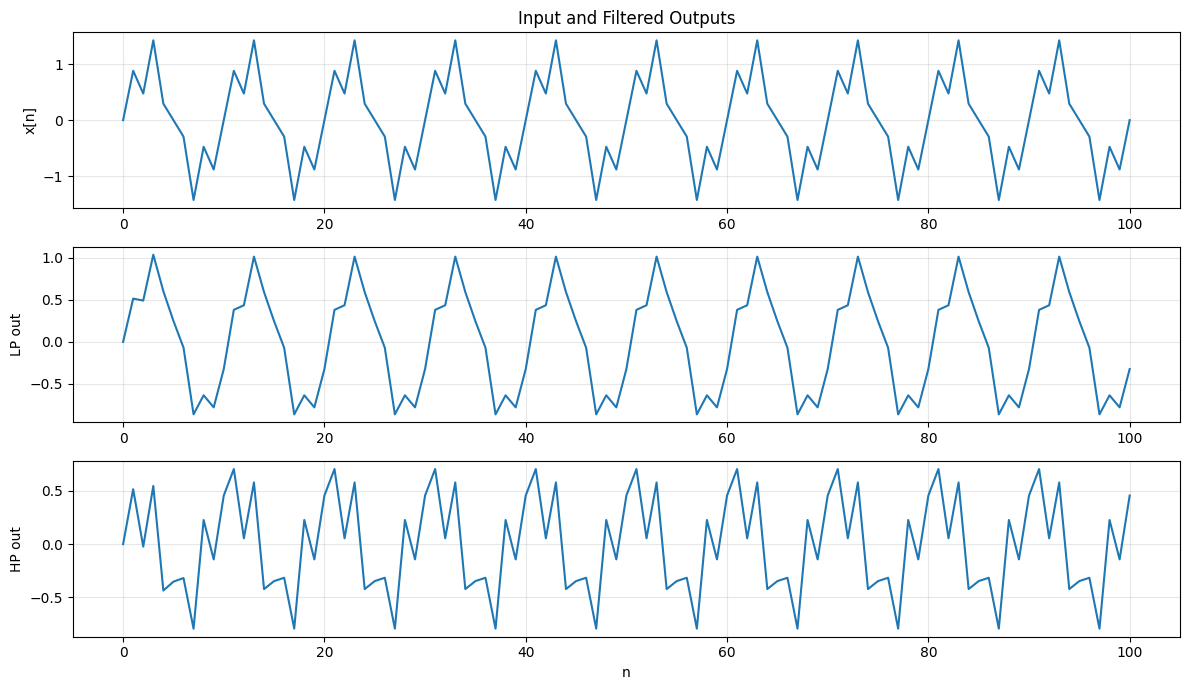

In [5]:
n = np.arange(0, 101)
x = np.sin(0.2*np.pi*n) + 0.5*np.sin(0.8*np.pi*n)

y_lp = signal.lfilter(b_lp, a_lp, x)
y_hp = signal.lfilter(b_hp, a_hp, x)

plt.figure(figsize=(12, 7))
plt.subplot(3, 1, 1)
plt.plot(n, x)
plt.title("Input and Filtered Outputs")
plt.ylabel("x[n]")
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(n, y_lp)
plt.ylabel("LP out")
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(n, y_hp)
plt.ylabel("HP out")
plt.xlabel("n")
plt.grid(True, alpha=0.3)
plt.tight_layout()

def gain_at(omega, Hfun):
    return np.abs(Hfun(np.array([omega]))[0])
g_lp_02 = gain_at(0.2*np.pi, H_lp)
g_lp_08 = gain_at(0.8*np.pi, H_lp)
g_hp_02 = gain_at(0.2*np.pi, H_hp)
g_hp_08 = gain_at(0.8*np.pi, H_hp)
print("(d) Gains @ 0.2π:  LP={:.3f}, HP={:.3f}".format(g_lp_02, g_hp_02))
print("(d) Gains @ 0.8π:  LP={:.3f}, HP={:.3f}".format(g_lp_08, g_hp_08))


(e) LPF pole-zero: poles [0.4150435], stable=True
(e) HPF pole-zero: poles [0.4150435], stable=True


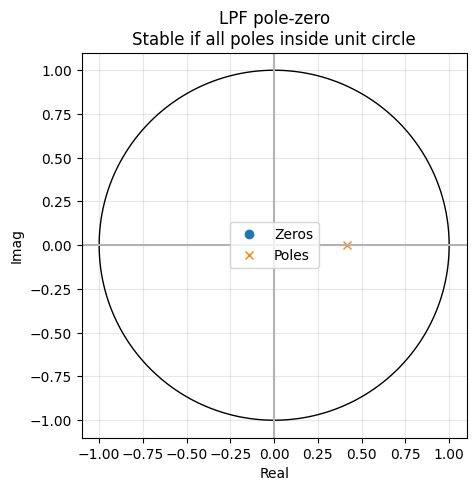

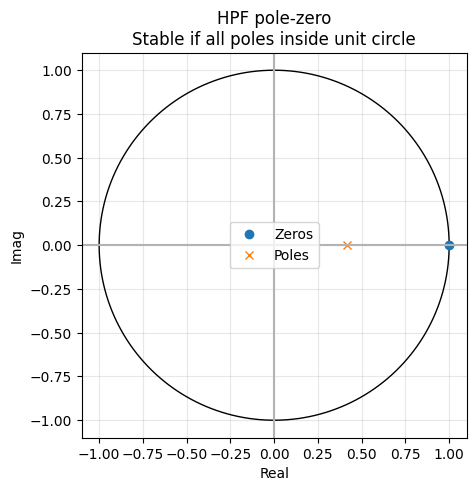

In [7]:
def pz_plot(b, a, title):
    b = np.trim_zeros(np.array(b, dtype=float), 'f')
    a = np.trim_zeros(np.array(a, dtype=float), 'f')
    z = np.roots(b) if len(b) > 1 else np.array([]) 
    p = np.roots(a)

    th = np.linspace(0, 2*np.pi, 400)
    uc = np.exp(1j*th)

    plt.figure(figsize=(5, 5))
    plt.plot(uc.real, uc.imag, 'k', linewidth=1) 
    if z.size:
        plt.plot(z.real, z.imag, 'o', label='Zeros')
    else:
        plt.plot([], [], 'o', label='Zeros')
    plt.plot(p.real, p.imag, 'x', label='Poles')
    plt.axhline(0, color='0.7'); plt.axvline(0, color='0.7')
    plt.gca().set_aspect('equal', 'box')
    plt.title(title + "\nStable if all poles inside unit circle")
    plt.xlabel('Real'); plt.ylabel('Imag')
    plt.legend()
    plt.grid(True, alpha=0.3)
    stable = np.all(np.abs(p) < 1 - 1e-12)
    print(f"(e) {title}: poles {p}, stable={stable}")

pz_plot(b_lp, a_lp, "LPF pole-zero")
pz_plot(b_hp, a_hp, "HPF pole-zero")

plt.show()